 <h1 style="font-size:50px;"><center>Boston: A Cold City</center></h1>

# Table of Contents
- [Introduction](#Introduction)
- [Datasets](#Links-to-datasets)
- [Cleaning up our data](#Cleaning-up-our-Data)
- [Counting Snow-related 311 Requests](#Counting-Snow-Related-311-Requests)
- [Wording of 311 Requests in Extreme Weather](#311-Request-Types-in-Extreme-Weather)
- [311 Requests by Region](#311-Reports-by-Region)
- [311 Requests by Median Household Income](#311-Reports-by-Median-Household-Income)
- [Conclusion](#Conclusion)

# Introduction
Boston is a cold city. The weather in Boston affect the city in various aspects. Among these, we are mainly looking for the relationship between weather and 311 reports.

# Links to datasets

[Boston Weather 2013-2018](https://www.kaggle.com/jqpeng/boston-weather-data-jan-2013-apr-2018)

[311 Dataset](https://data.boston.gov/dataset/311-service-requests)

[Income Data Source](https://www.boston.gov/search?utf8=%E2%9C%93&query=data&facet%5B%5D=documents)

## Methods

### Questions we've asked
- # of reports that contain the word snow when there is no snow on that day (and vise versa)
- Do 311 requests come mostly from one region?
- Is median household income correlated with number of 311 requests?
- Within how many days of snowfall do requests for plowing happen?

# Cleaning up our Data
Before we can ask any questions of our data, we need to put it in a form condusive to analysis. We start by loading each dataset, and cleaning up those columns that will be used for merging with other datasets. We also do any computations that are most easily done pre-merging.

In [1]:
# All imports go in this block
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from re import sub
from decimal import Decimal
from wordcloud import WordCloud, STOPWORDS

## Weather Data

In [2]:
# Load the weather dataset
df_weather = pd.read_csv("data/Boston weather_clean.csv")

For the purposes of answering questions about Snow in Boston, it would be helpful to know a few things about how likely it is that snow is around.

#### consecutive_snow_days
First of all, it would be helpful if each day was labelled by whether it was the first day of snowfall, or the third day of a long snow storm. For this reason, we add the *consecutive_snow_days* column.

#### days_since_last_snow
Next, for those days on which no snow was reported, it would be nice to know if there had recently been snowfall, which would cause snow to still affect 311 requests on that day. For this reason we added the *days_since_last_snow* column to the dataset.

#### accumulated_snow
Lastly, in case we want to look at accumulated snow over several days, we keep track of an *accumulated_snow* column, which adds up the snowfall in inches for consecutive snow days.

In [3]:
# Compute snow-related metrics
consecutive_snow_days = [0]
days_since_last_snow = [365]
accumulated_snow = [0]
for index, row in df_weather.iterrows():
    if row['Events'] == 'Snow' or row['Events'] == 'Both' or row['Snowfall (in)'] > 0:
        if consecutive_snow_days[-1] == 0:
            accumulated_snow.append(float(row['Snowfall (in)']))        
        else:
            accumulated_snow.append(accumulated_snow[-1] + row['Snowfall (in)'])
        consecutive_snow_days.append(consecutive_snow_days[-1] + 1)
        days_since_last_snow.append(0)
    else:
        accumulated_snow.append(accumulated_snow[-1])
        consecutive_snow_days.append(0)
        days_since_last_snow.append(days_since_last_snow[-1] + 1)
df_weather['consecutive_snow_days'] = consecutive_snow_days[1:]
df_weather['days_since_last_snow'] = days_since_last_snow[1:]
df_weather['accumulated_snow'] = accumulated_snow[1:]

## 311 Data
We downloaded the 311 dataset from data.boston.gov. In order to merge it with the weather dataset, we split the open date of each request into three columns (Year, Month, and Day). We chose the *open date* rather than the *close date* because we figured the weather most relevant to a request would be the weather at the time of opening, and not when it was closed.

In [4]:
# Load 311 dataset
df_311 = pd.read_csv('data/311.csv')

/Users/matt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Split out the date column into separate Year Month and Day columns
df_311['open_dt'] = pd.to_datetime(df_311['open_dt'])
df_311['Year'] = df_311['open_dt'].apply(lambda date: date.year)
df_311['Month'] = df_311['open_dt'].apply(lambda date: date.month)
df_311['Day'] = df_311['open_dt'].apply(lambda date: date.day)

In [6]:
# Merge the datasets. This performs an INNER JOIN which keeps only items
# that are present in both datasets.
df_311_weather = pd.merge(df_311, df_weather, on=['Year', 'Month', 'Day'])

## Income Data
We found the median household income for each region of Boston, and decided to include it in our dataset to try to see if we can find some interesting correlations between income and 311 requests.

In [98]:
df_income = pd.read_csv('data/median income.csv', delimiter=";")

In [99]:
def convert_neighborhood(neighborhood):
    """
    Match neighborhoods in the 311 dataset with regions in the income dataset
    """
    conversions = [("Allston / Brighton", "Allston/Brighton"),
                   ("Allston", "Allston/Brighton"),
                   ("Brighton", "Allston/Brighton"),
                   ("Back Bay", "Back Bay/Beacon Hill"),
                   ("Beacon Hill", "Back Bay/Beacon Hill"),
                   ("Fenway / Kenmore / Audubon Circle / Longwood", "Fenway/Kenmore"),
                   ("Greater Mattapan", "Mattapan"),
                   ("Downtown / Financial District", "Boston"),
                   ("Mission Hill", "West Roxbury"),
                   ("South Boston / South Boston Waterfront", "South Boston"),
                   ("Chestnut Hill", "Allston/Brighton")]
    for left, right in conversions:
        if neighborhood == left:
            return right
    return neighborhood

In [100]:
df_311_weather['neighborhood'] = df_311_weather['neighborhood'].apply(convert_neighborhood)

In [101]:
# Clean up dollar strings into numbers
df_income['median household income'] = df_income['median household income'].apply(lambda money: Decimal(sub(r'[^\d.]', '', str(money))))

In [102]:
df_income

region median household income  population
0                 Boston                   52433       31.82
1              Hyde Park                   53474       31.85
2            Charlestown                   83926       16.44
3            East Boston                   43511       40.51
4                Roxbury                   30654       52.53
5              South End                   51870       30.36
6   Back Bay/Beacon Hill                   82742       31.82
7         Fenway/Kenmore                   32509       38.38
8       Allston/Brighton                   52362       74.80
9               Mattapan                   42164       34.39
10            Roslindale                   62702       27.62
11          West Roxbury                   71066       30.44
12            Dorchester                   45807       88.33
13          South Boston                   63747       33.69
14        Central Boston                   65662        1.98
15         Jamaica Plain                   55861       41.26

In [103]:
df_311_weather_income = pd.merge(df_311_weather, df_income, left_on="neighborhood", right_on="region", how="left")

## Our final combined dataset:
After merging all of our data sources into one dataset, we get a table in which each row is a 311 request, and the columns include information about that 311 request, what the weather was that day, and the median household income of the region in which the request was made. Below is a sample of this dataset, showing only the columns that are of interest to us. (Scroll right to see the new columns)

In [104]:
df = df_311_weather_income.filter(['Year', 'Month', 'Day', 'case_title', 'reason', 'type', 'neighborhood', 'High Temp (F)', 'Avg Temp (F)', 'Low Temp (F)', 'High Wind (mph)', 'Avg Wind (mph)', 'High Wind Gust (mph)', 'Snowfall (in)', 'Precip (in)', 'Events', 'consecutive_snow_days', 'days_since_last_snow', 'accumulated_snow', 'median household income', 'population'])
df

Year  Month  Day                           case_title  \
0        2011      7    1                 Street Light Outages   
1        2011      7    1          Schedule a Bulk Item Pickup   
2        2011      7    1                 Street Light Outages   
3        2011      7    1                  Highway Maintenance   
4        2011      7    1                      Sticker Request   
5        2011      7    1          Schedule a Bulk Item Pickup   
6        2011      7    1          Schedule a Bulk Item Pickup   
7        2011      7    1          Schedule a Bulk Item Pickup   
8        2011      7    1          Schedule a Bulk Item Pickup   
9        2011      7    1       Graffiti: Ward 10  1009  Other   
10       2011      7    1            Pothole Repair (Internal)   
11       2011      7    1            Pothole Repair (Internal)   
12       2011      7    1            Pothole Repair (Internal)   
13       2011      7    1            Pothole Repair (Internal)   
14       2011      7    1            Pothole Repair (Internal)   
15       2011      7    1            Pothole Repair (Internal)   
16       2011      7    1            Pothole Repair (Internal)   
17       2011      7    1            Pothole Repair (Internal)   
18       2011      7    1            Pothole Repair (Internal)   
19       2011      7    1            Pothole Repair (Internal)   
20       2011      7    1            Pothole Repair (Internal)   
21       2011      7    1            Pothole Repair (Internal)   
22       2011      7    1            Pothole Repair (Internal)   
23       2011      7    1           Sidewalk Repair (Internal)   
24       2011      7    1            Pothole Repair (Internal)   
25       2011      7    1            Pothole Repair (Internal)   
26       2011      7    1            Pothole Repair (Internal)   
27       2011      7    1                  Highway Maintenance   
28       2011      7    1            Pothole Repair (Internal)   
29       2011      7    1            Pothole Repair (Internal)   
...       ...    ...  ...                                  ...   
1228622  2018      4    7          Poor Conditions of Property   
1228623  2018      4    7                         PRINTED : JK   
1228624  2018      4    7                  Parking Enforcement   
1228625  2018      4    7  Improper Storage of Trash (Barrels)   
1228626  2018      4    7  Improper Storage of Trash (Barrels)   
1228627  2018      4    7           Request for Pothole Repair   
1228628  2018      4    7                  Parking Enforcement   
1228629  2018      4    7                  Parking Enforcement   
1228630  2018      4    7                  Parking Enforcement   
1228631  2018      4    7                  Parking Enforcement   
1228632  2018      4    7                  Parking Enforcement   
1228633  2018      4    7                         PWD Graffiti   
1228634  2018      4    7           Request for Pothole Repair   
1228635  2018      4    7           Request for Pothole Repair   
1228636  2018      4    7                  Parking Enforcement   
1228637  2018      4    7           Request for Pothole Repair   
1228638  2018      4    7                  Parking Enforcement   
1228639  2018      4    7            Schedule Bulk Item Pickup   
1228640  2018      4    7                  Parking Enforcement   
1228641  2018      4    7                  Parking Enforcement   
1228642  2018      4    7               Animal Generic Request   
1228643  2018      4    7           Request for Pothole Repair   
1228644  2018      4    7                  Parking Enforcement   
1228645  2018      4    7                      Rodent Activity   
1228646  2018      4    7                  Pick up Dead Animal   
1228647  2018      4    7                  Parking Enforcement   
1228648  2018      4    7                  Parking Enforcement   
1228649  2018      4    7                  Parking Enforcement   
1228650  2018      4    7                  Parkin

# Counting Snow-Related 311 Requests

In [14]:
# Make sure plt is in a clean state
plt.rcdefaults()

# changes the type of the values under the column “case_title”
# into a string
df["case_title"] = df["case_title"].astype(str)

# function that generates graphs according to
# which dataset has been passed in
def graph_snow_requests_vs_actual_requests(df):
    
    # lists all the data in which there was snowfall
    # by finding all the values under the “snowfall (in)” column that
    # has a value greater than 0.
    snowed = df["Snowfall (in)"] > 0
    snow_data = df[snowed]

    # filters dataset to give data in which the case title of the 311 report
    # includes the string “snow”
    has_snow = df["case_title"].str.contains("Snow")
    reason_snow = df[has_snow]
    
    # lists all the data in which there wasn't snowfall
    # by finding all the values under the “snowfall (in)” column that
    # has a value of exactly 0.
    no_snow = df["Snowfall (in)"] == 0

    # code to get dataset in which there wasn't snow but still had report(s) on snow
    # by filtering dataset by the conditions in which it didn’t snow, yet has a 
    # 311 report on that day in which the report title had the word “snow” in it. 
    no_snow_data = df[no_snow & has_snow]
    
    # counts the number of instances in which there was no snow, yet there was
    # at least one 311 report that had the word “snow” in its title
    count_no = no_snow_data['case_title'].count()
    
    # data has been filtered to show only those in which there was snow, and also
    # 311 reports with the word “snow” in its title
    yes_snow_data = df[snowed & has_snow]
    
    # counts the number of instances in which there was snow, and also
    # at least one 311 report that had the word “snow” in its title
    count_yes = yes_snow_data['case_title'].count()

    # code gets all the data in which the case title of the 311 report does
    # NOT have the word “snow” in it
    no_word = df["case_title"].str.contains("Snow") == False
    reason_nosnow = df[no_word]
    
    # filters dataset to get all the data in which there was snowfall, but no 311
    # report with the case title having the word “snow” in it
    yesSnow_noReport = df[snowed & no_word]
    
    # counts the number of instances in which there was snowfall, but no
    # 311 report that had the word “snow” in its case title
    count_noSnowReport = yesSnow_noReport['case_title'].count()
    
    # filters dataset to get all the data in which there was no snowfall,and no 311
    # reports with the case title having the word “snow” in it
    noSnow_noReport = df[no_snow & no_word]
    
    # counts the number of instances in which there was no snowfall, and also no
    # 311 reports with the word “snow” in its case title
    count_noSnownoReport = noSnow_noReport['case_title'].count()

    # First graph
    # Code to draw a bar graph where we can see the number of 311 reports that 
    # either has the word “snow” in its case title or not when there was snowfall.
    # The values of the bars are from the count of instances in which there was 
    # snowfall but no 311 reports that had the word “snow” in the case title, and 
    # another from when there was snowfall and also had 311 reports that had a case 
    # title with the word “snow” in it.
    x_pos = ('"snow" exists', '"snow" doesnt exist')
    y_pos = np.arange(len(x_pos))
    performance = [count_yes,count_noSnowReport]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, x_pos)
    plt.ylabel('Number of 311 requests')
    plt.xlabel('Whether the word "snow" exists within the 311 report title')
    plt.title('Having the word "snow" in 311 requests when there WAS snowfall')

    plt.show()
    
    # Second graph
    # Code to draw the bar graph in which we can see the number of 311 reports that 
    # either has the word “snow” in its case title or not when there was NO snowfall.
    # The values of the bars are from the count of instances in which there was no
    # snowfall, and also no 311 reports that has the word “snow” in its case title, and
    # another count from when there was no snowfall, yet there were 311 reports in which
    # the case title had the word “snow” in its case title
    x_pos = ('"snow" exists', '"snow" doesnt exist')
    y_pos = np.arange(len(x_pos))
    performance = [count_no,count_noSnownoReport]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, x_pos)
    plt.ylabel('Number of 311 requests')
    plt.xlabel('Whether the word "snow" exists within the 311 report title')
    plt.title('Having the word "snow" in 311 requests when there WAS NO snowfall')

    plt.show()

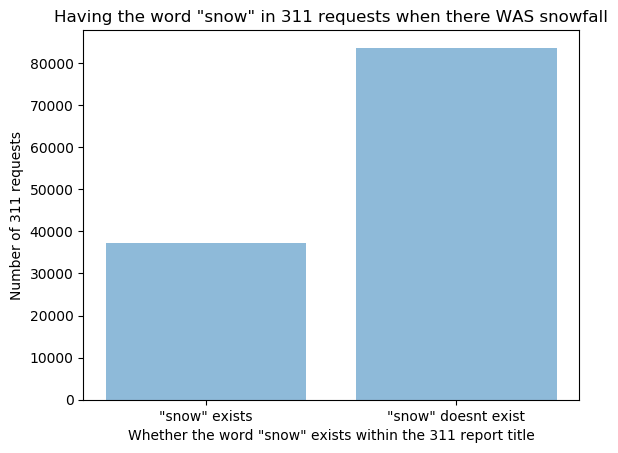

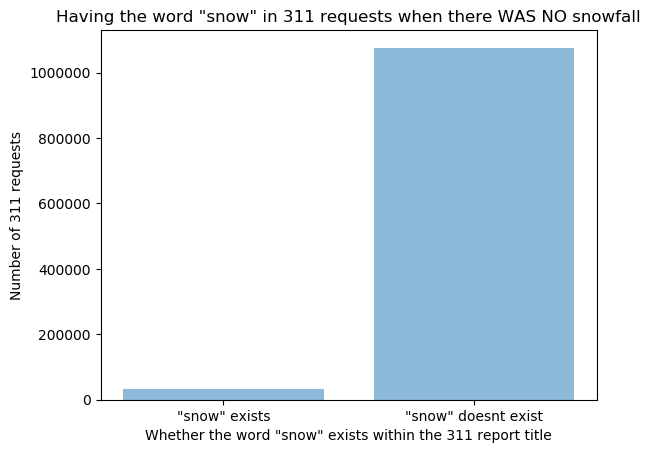

In [15]:
graph_snow_requests_vs_actual_requests(df)

Note: This dataset is from 2011 to 2018, inclusive of all seasons

### Interpretation of FIRST bar graph above:
There are more reports in which the word “snow” doesn’t exist within
the case title even though there is snow, and there are many reasons as
to why that might be the case. First of all, “snowfall” in our dataset
is anything where there is more than 0 inches of snow, and when there is
only an inch or so of snow, it doesn’t really negatively impact the
community so much.
Also, not all snow-related reports include the word “snow” in the title.
It can be something like “frozen road”, or “requests for street cleaning”
and so forth, which means those reports will be omitted from our count
because we are only looking at data in which the word “snow” is explicitly
included in the title.


### Interpretation of SECOND bar graph above:
Looking at the graph, there are more reports in which the word “snow” 
doesn’t exist within the case title when there is no snow. The most
obvious reason as to why there are more reports explicitly unrelated to 
snow is because this dataset includes all seasons from 2011 to 2018. 
Boston gets pretty snowy during the winter months, but it is rare to 
have snow from spring to fall, and because our dataset includes all 
seasons, obviously, we will have many more reports that are unrelated
to snowfall.

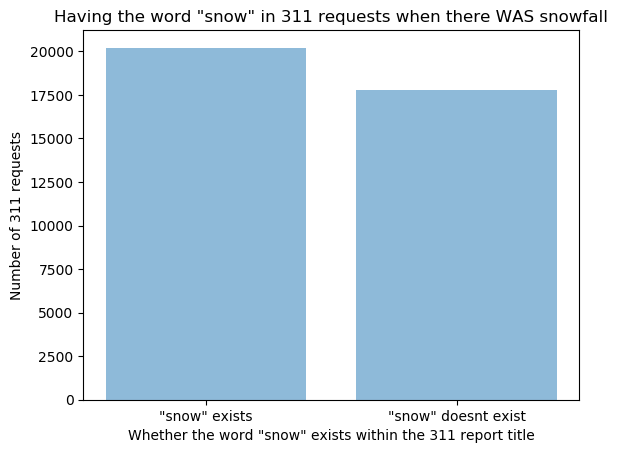

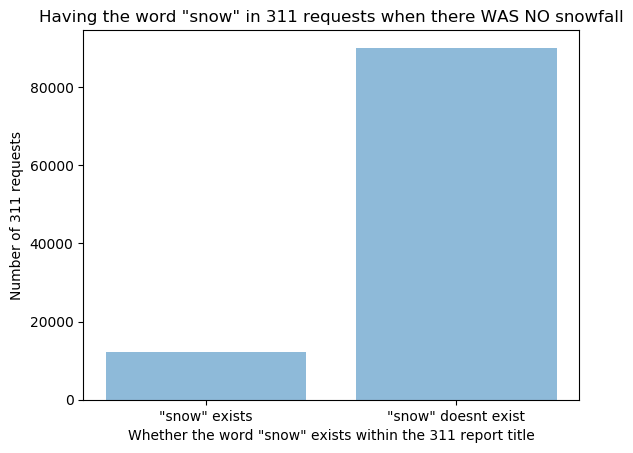

In [16]:
winter_2014_2015 = (df['Year'] == 2014) & (df['Month'] > 8) | ((df['Year'] == 2015) & (df['Month'] < 5))
graph_snow_requests_vs_actual_requests(df[winter_2014_2015])

Note: This dataset is from 2014 to 2015, only including the winter months

### Interpretation of FIRST bar graph:
Unlike the bar graph above with the same question, with this dataset that only
includes the winter months, we now have more 311 requests with the word “snow”
in the case title. We explicitly picked the winter of 2014 to 2015 because
those were the years in which there was a lot of snowfall, and probably because
of that reason, we subsequently also had a lot more 311 requests relating to snow. 
Of course like what I have stated above, this count omits requests that do not
explicitly have the word “snow” in the case title, but even then, we still have 
more reports with the word “snow” within the title. This fact tells us that the 
winter of 2014-2015 was indeed quite severe in terms of the degree of how much
the weather negatively affected the residents of Boston.

### Interpretation of SECOND bar graph:
Similar to the bar graph above with the same question, the graph of the dataset 
that only includes the winter months also has more 311 requests where the word
“snow” doesn’t exist in the case title when there was no snowfall. The reason why
is probably due to the fact that because there was no snow for the day, there were
also less problems, or at least less severe problems related to snow. We still
do have reports explicitly relating to snowfall, and those are probably due to the
remnants of snow from the snowy weather the day before or so.

# 311 Request Types in Extreme Weather

Next, we investigate a few types of extreme weather, and how these types of weather may affect the kinds of 311 requests that come in. These are **windy**, **snowy**, **chilly**. It is interesting to see which sorts of requests occur more for certain types of weather than others.

One visually effective way to observe trends in word choice is by generating word clouds. Below, we define which requests fit our criteria for each weather type, and then we generate wordclouds from the request text for those requests.

In [40]:
## WINDY ##
windy = df['Avg Wind (mph)'] > 30

## SNOWY ##
snowy = df['days_since_last_snow'] < 2

## CHILLY ##
celcius = df['Low Temp (F)'].apply(lambda x: (x - 32) * (5.0/9.0))
chilly = celcius < (-20)

In [41]:
def make_wordcloud_from_text(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'white',
        stopwords = STOPWORDS).generate(text)
    fig = plt.figure(
        figsize = (20, 15),
        facecolor = 'white',
        edgecolor = 'white')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
def make_wordcloud(df):
    text_cols = ['reason', 'type']
    make_wordcloud_from_text(" ".join(df[col_name].str.cat(sep=" ") for col_name in text_cols))

## Snowy
The first type of extreme weather that we showcase is the **snowy** case. We define this to be days on which it snowed, as well as the two days immediately following a snow day. The biggest words are Snow Plowing Request, which fits our expectations. There are also requests to repair potholes, and reports of missed trash pickups. There are many requests for Scheduled Bulk Item Pickup, which baffles us a little bit - perhaps these are reports of missed pickups. 

An interesting snow-related request is "Parking Enforcement" - I wonder how many of these are people who had marked their spot with lawn chairs. More likely, since snow makes many previous parking spaces unviable, people are more likely to park illegally and thus trigger more parking enforcement-related 311 calls.

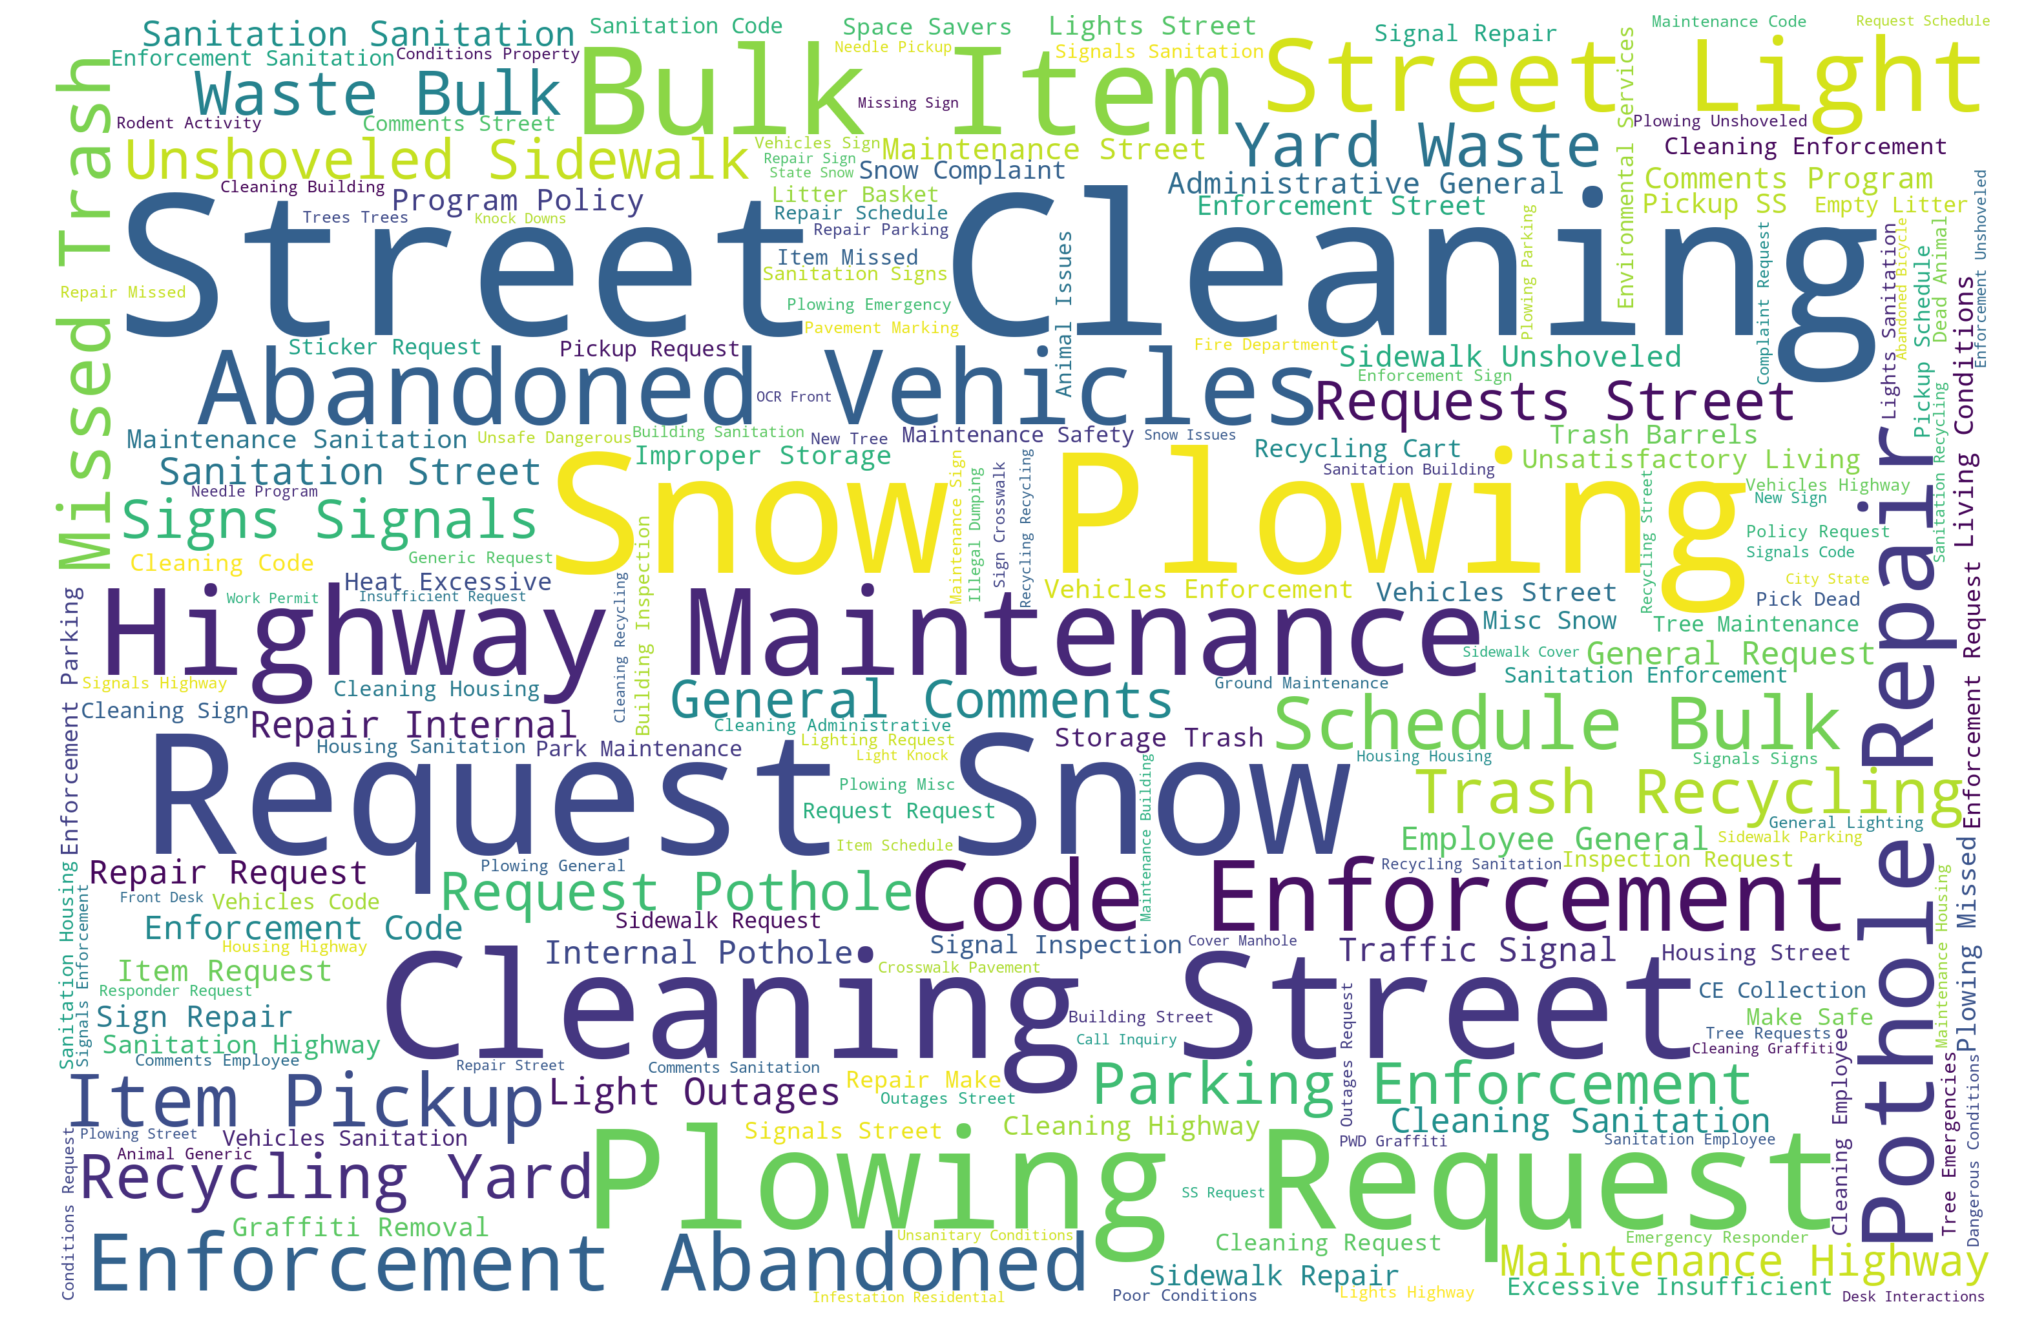

In [22]:
make_wordcloud(df[snowy])

## Windy
In the wordcloud below, observe the words that come up most often for windy days (days with an average windspeed of 30 mph or higher). Tree related requests, as well as Downed Wire reports are very common. Street lights, traffic lights, signal repair, all seem to show that Boston's traffic flow control infrastructure is vulnerable to high winds. There are also many requests for street cleaning

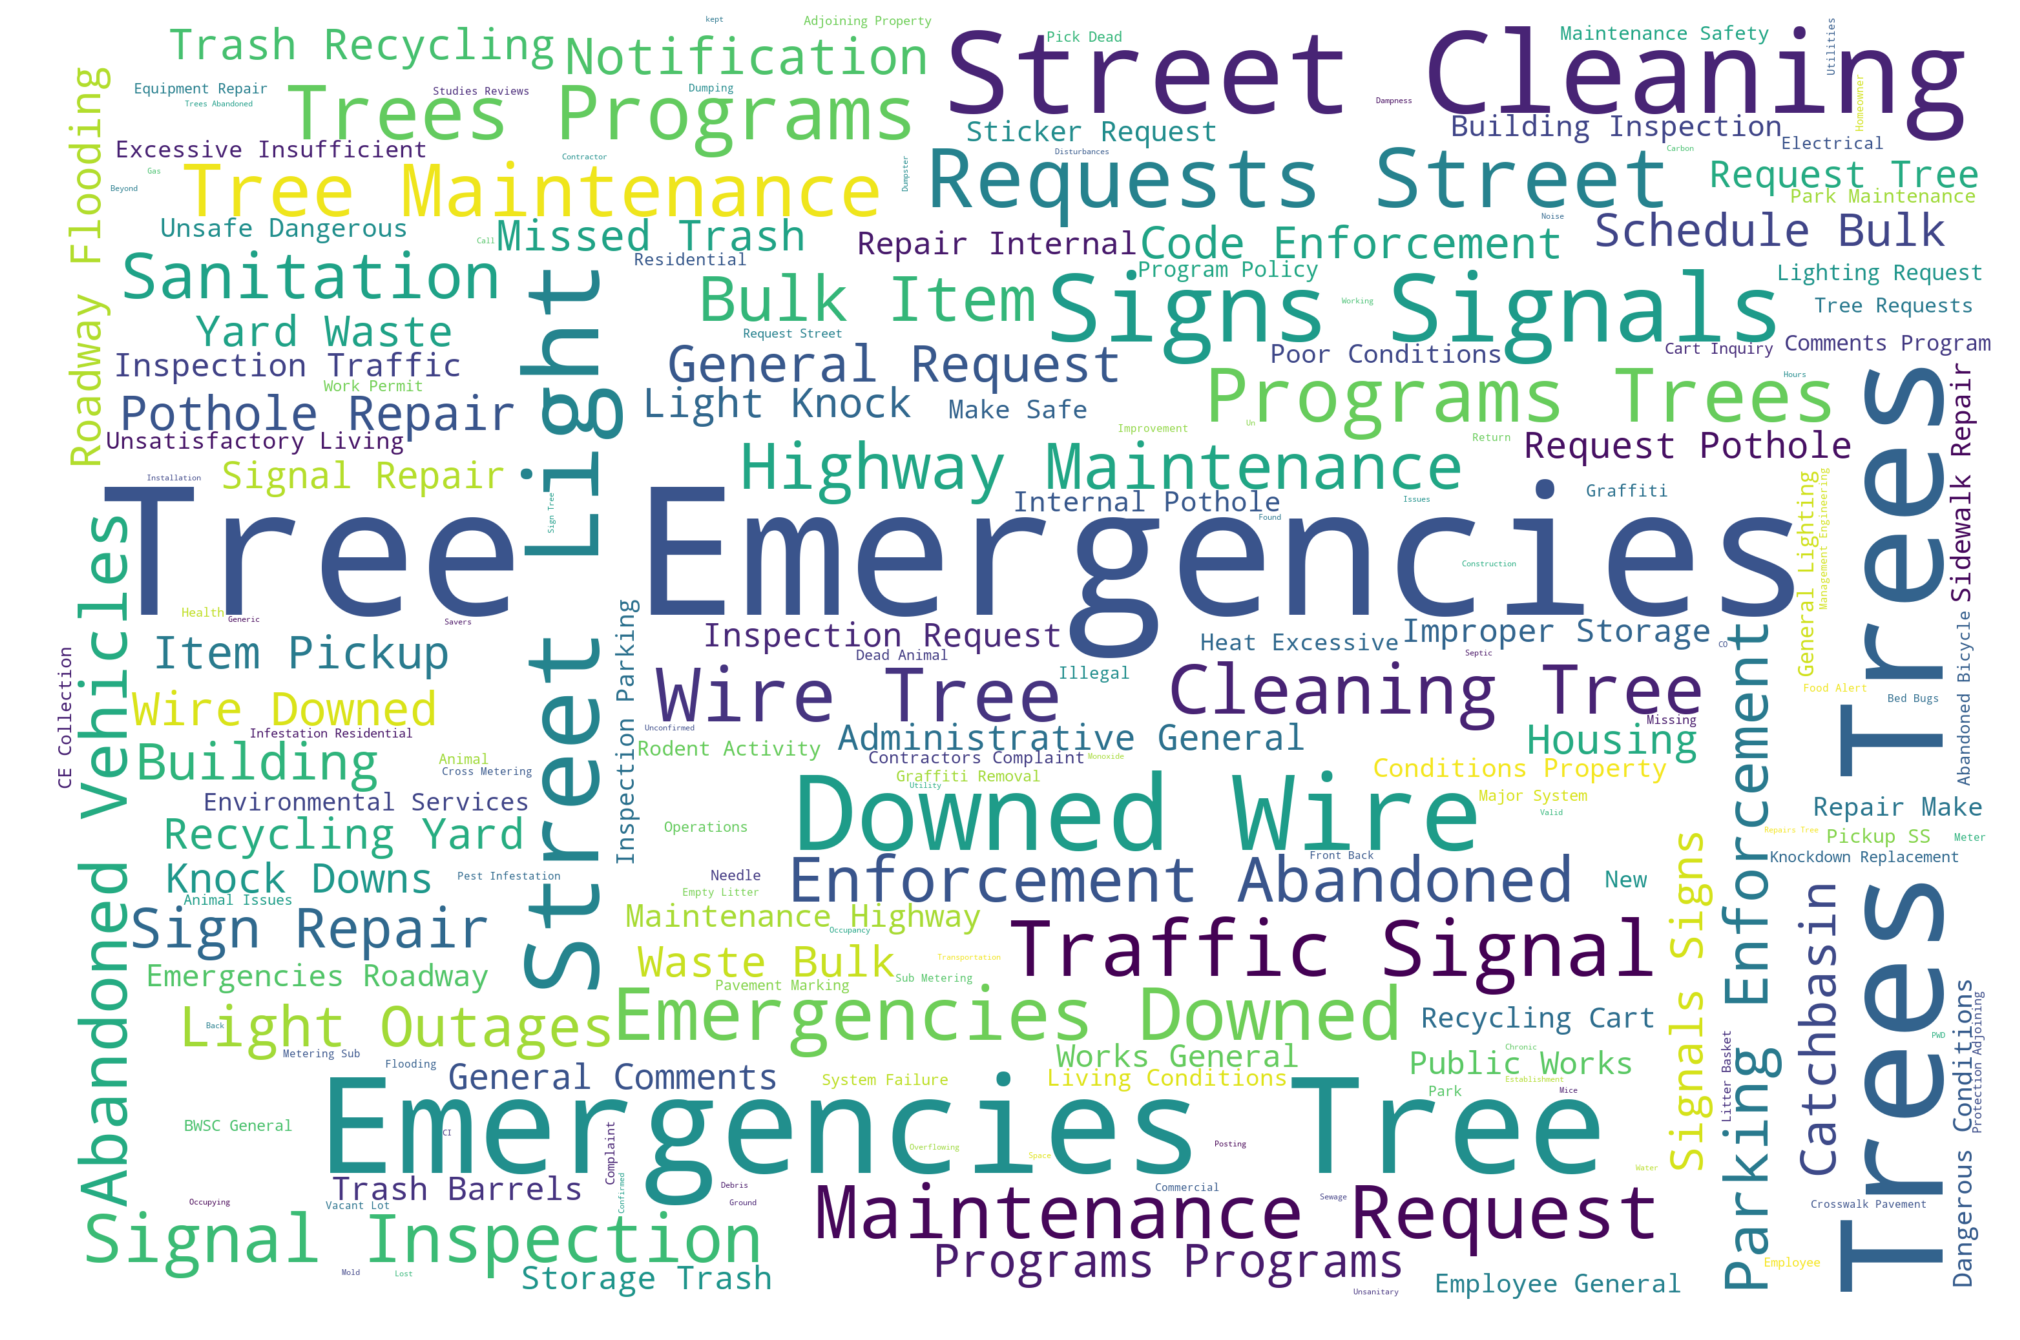

In [23]:
make_wordcloud(df[windy])

## Chilly
Snow is only one of the challenges Bostonians face in the winter. The other one is just sheer cold. What kinds of calls do Bostonians make in subfreezing temperatures?

The biggest words by far come from the request "Heat Excessive Insufficient" which seems like a catch-all type for heating related issues. 

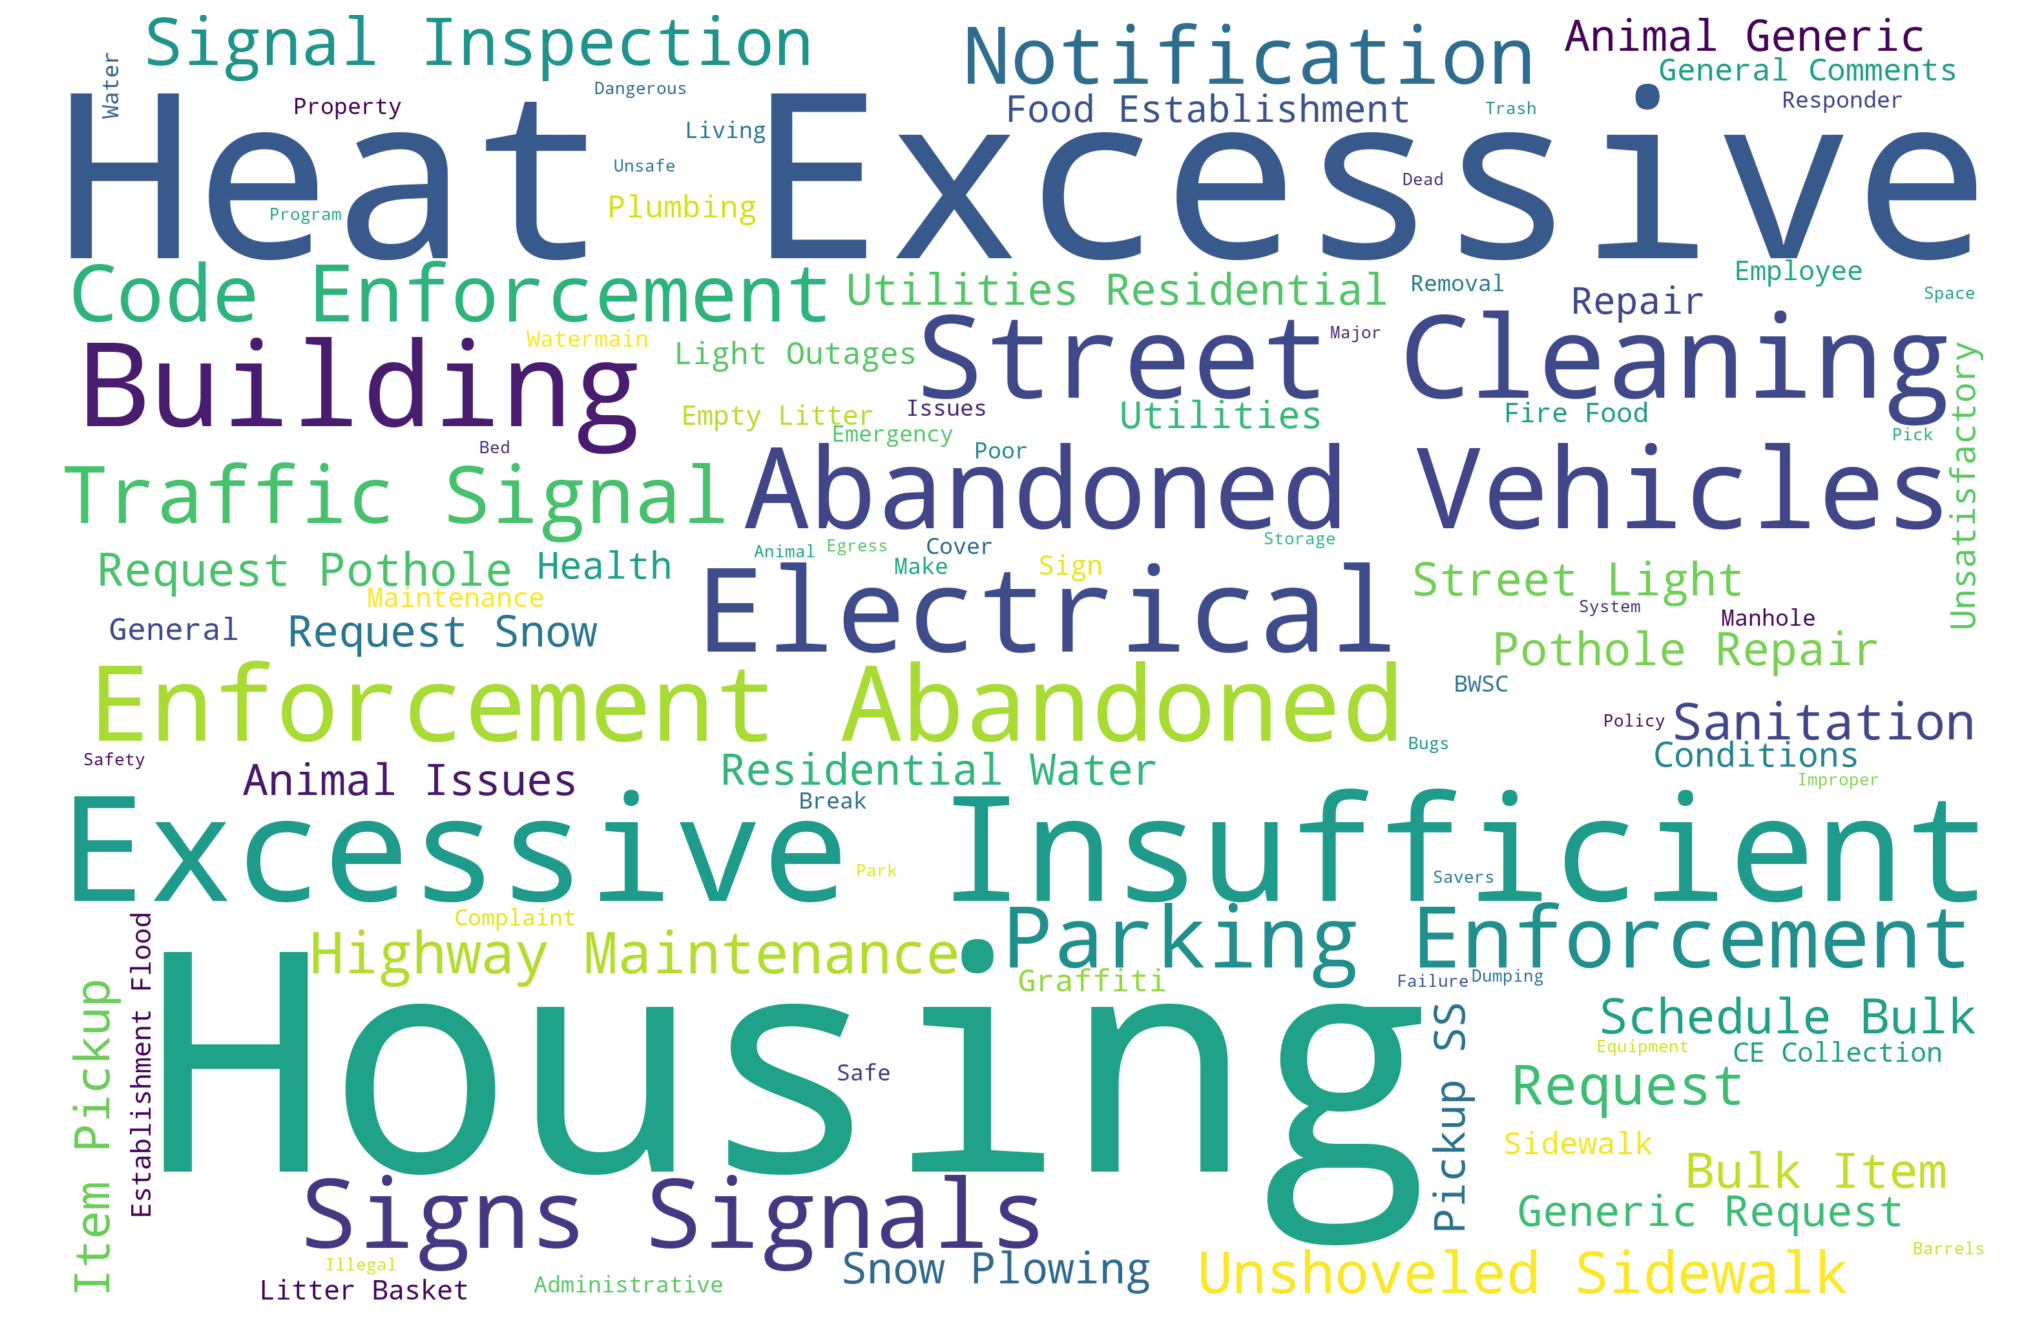

In [24]:
make_wordcloud(df[chilly])

# 311 Reports by Region
Here, we correlate the frequency of 311 reports with each region in Boston by counting the occurrences of each neighborhood in the "neighborhood" column of the 311 dataset.

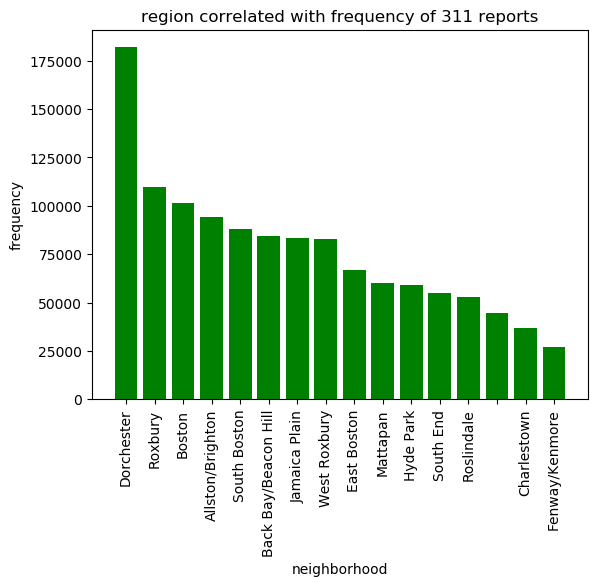

In [105]:
# Data manipulation: get counts of reports by neighborhood
def plot_reports_by_region(value_counts):
    x_pos = np.arange(len(value_counts.keys()))
    plt.bar(x_pos, list(value_counts[key] for key in value_counts.keys()), align='center',
            color='green', ecolor='black')
    plt.xticks(x_pos, value_counts.keys(), rotation='vertical')
    plt.xlabel("neighborhood")
    plt.ylabel("frequency")
    plt.title("region correlated with frequency of 311 reports")
    plt.show()

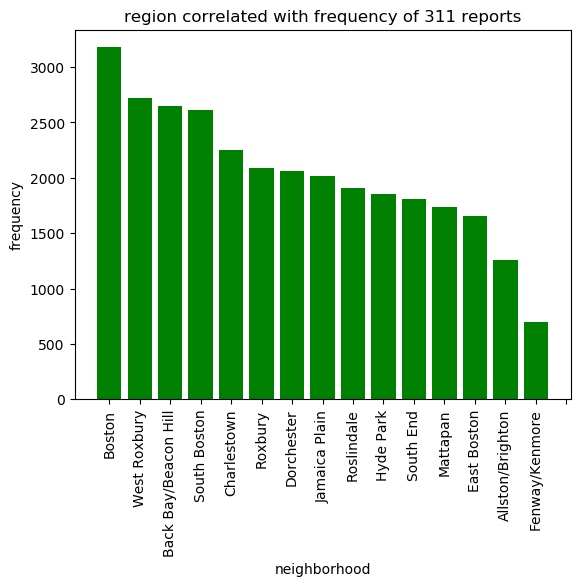

In [109]:
new_df = df.groupby(by="neighborhood").aggregate({'case_title': 'count',
                                                  'population': 'max'})

plot_reports_by_region((new_df['case_title'] / new_df['population']).sort_values(ascending=False))

The data is sorted from the most to the least. From the image, we can tell that Dorchester has the most 311 reports, which is a lot more than the other regions. We looked up the population of each region and found that Dorchester has the largest population following by Roxbury and Brighton. Thus we guess that the frequency of 311 reports of each region has a direct relationship with the population of that region.

Source: [Boston population by neighborhood](https://statisticalatlas.com/place/Massachusetts/Boston/Population#figure/neighborhood/total-population)

# 311 Reports by Median Household Income
After looking at which regions have the most 311 requests, we looked at the median household income of each of those regions to try to find a correlation between median household income and frequency of 311 requests.

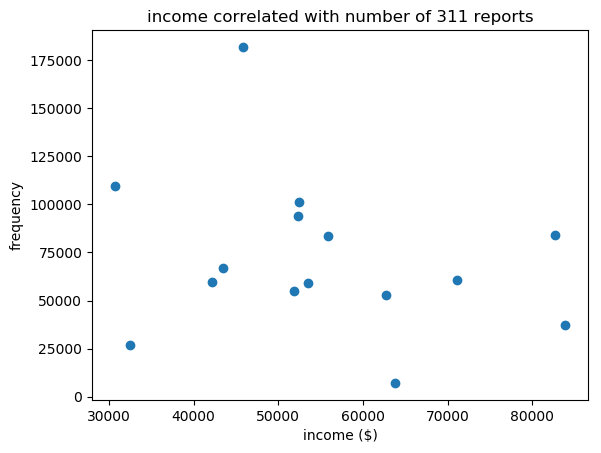

In [26]:
# Data manipulation: get counts of reports by region
value_counts = df["median household income"].value_counts()

# Plot how many of our reports come from low vs high income areas
plt.scatter(list(map(lambda x: int(x), value_counts.keys())), list(value_counts[key] for key in value_counts.keys()))
plt.xlabel("income ($)")
plt.ylabel("frequency")
plt.title("income correlated with number of 311 reports")
plt.show()

We relate the median income of each region and the frequency of 311 reports into a dot plot. Looking through the median income, most of the corresponding frequency data are gathered in the rage of 2500 to 10000, regardless of the income. We thought there might be more reports in the relatively poor regions, however we can’t draw any pattern from the dot plot. Thus the income and the frequency of 311 reports don’t have a direct relationship.

## Conclusion

- Not sure how to normalize our data
- Snow has a delayed effect - requests related to snow can happen the day after it snows

Correlate 311 with demographics (income, race, etc)

correlate region with frequency of 311 reports
correlate income with frequency of 311 reports

correlate weather with type of 311 report
correlate weather with number of 311 reports on that day



1. Make visualizations (individually) using our merged dataset
2. Look at those visualizations and come up with more questions to ask about the data


3. Merge demographics dataset into current dataset


In [44]:
# What is the average days_since_last_snow for snow removal requests
# 1. filter the table for only entries about snow removal
plow_requests = df['case_title'].str.contains("Snow", na=False)
# 2. for those entries, compute the average of days_since_last_snow
print(df[plow_requests & winter_2014_2015]['days_since_last_snow'].mean())
print(df[plow_requests]['days_since_last_snow'].mean())

0.281981759921124
0.41537880548454564
